In [47]:
from pathlib import Path
from functools import partial

import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torchvision.models import resnet50
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

from training_clipping import load_progan, RealVideos

In [3]:
progan = load_progan("jelito3d_batchsize8", "/shared/results/z1143165/jelito3d_batchsize8")

Average network found !


In [4]:
kwargs = {"num_workers": 8, "pin_memory": True, "batch_size": 1,
            "shuffle": True, "drop_last": True}
dataloader = DataLoader(RealVideos(root='/shared/results/Skopia/videos24frames', num_frame=24, duration=24), **kwargs)

In [71]:
real_video, time = next(iter(dataloader))
real_video = real_video.cuda()

In [72]:
img = real_video[:, 0]
img.shape

torch.Size([1, 3, 256, 256])

In [73]:
def from_torch(img):
    npimg = np.moveaxis(img.detach().cpu().numpy()[0], 0, 2)
    img = (npimg - npimg.min()) / (npimg.max() - npimg.min())
    return img

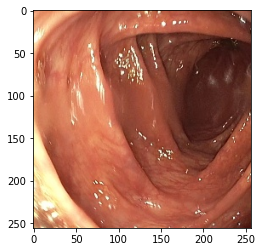

In [74]:
plt.imshow(from_torch(img))

In [75]:
for child in progan.netD.children():
    for param in child.parameters():
        param.requires_grad = False

In [76]:
loss = nn.MSELoss()

In [77]:
def loss_fn(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

In [78]:
def get_features(input):
    _, f = progan.netD.forward(input, True)
    return f

In [111]:
def improve_noise_with_features(model, noise=None, num_iters=400, lr=0.001):
    if noise is None:
        noise = torch.randn(1, 512)
    noise.requires_grad = True
    
    optimizer = torch.optim.Adam([noise], lr=lr)

    img_features = model(img)

    metrics = []
    progress = tqdm(range(num_iters))
    for i in progress:
        output = progan.netG(noise)
        output_features = model(output)
        cost = loss_fn(output_features, img_features).mean()
        metrics.append(cost.item())

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        progress.set_description(f"loss {cost.item()}")
    plt.plot(*np.array(list(enumerate(metrics))).T)

    return output

  0%|          | 0/400 [00:00<?, ?it/s]

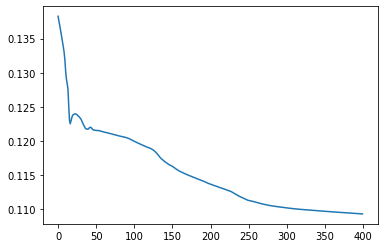

In [80]:
torch.manual_seed(0)
output = improve_noise_with_features(get_features, num_iters=400)

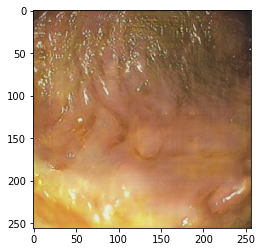

In [81]:
plt.imshow(from_torch(output))

In [82]:
resnet = resnet50().cuda()
for child in resnet.children():
    for param in child.parameters():
        param.requires_grad = False

  0%|          | 0/400 [00:00<?, ?it/s]

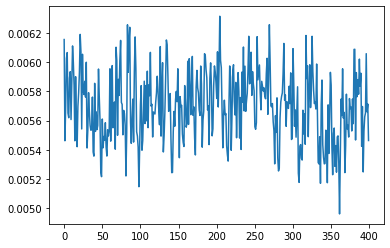

In [83]:
torch.manual_seed(0)
output = improve_noise_with_features(resnet, num_iters=400)

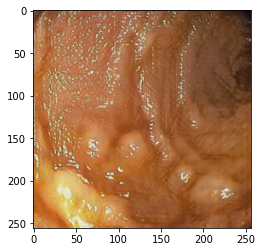

In [84]:
plt.imshow(from_torch(output))

In [85]:
def improve_noise_mse(noise=None, num_iters=400, lr=0.001):
    if noise is None:
        noise = torch.randn(1, 512)
    noise = noise.clone()
    noise.requires_grad = True
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam([noise], lr=lr)

    metrics = []
    progress = tqdm(range(num_iters))
    for i in progress:
        output = progan.netG(noise)
        cost = loss(output, img)
        metrics.append(cost.item())

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        progress.set_description(f"loss {cost.item()}")
    plt.plot(*np.array(list(enumerate(metrics))).T)

    return output

  0%|          | 0/400 [00:00<?, ?it/s]

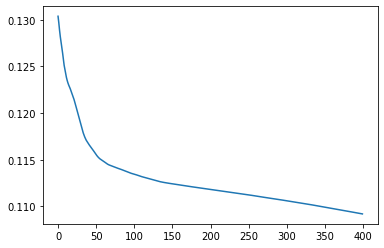

In [86]:
torch.manual_seed(0)
output = improve_noise_mse()

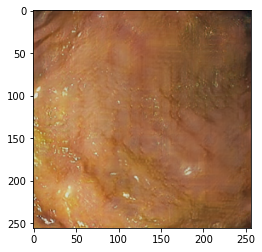

In [87]:
plt.imshow(from_torch(output))

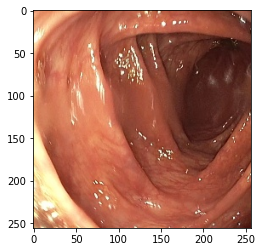

In [88]:
plt.imshow(from_torch(img))

In [89]:
loss = nn.MSELoss(reduction="none")
noise = torch.randn(8, 512)
output = progan.netG(noise)
idx = torch.argmin(loss(output, img).mean(dim=[1,2,3]))
new_noise = noise[idx][None]
output = progan.netG(new_noise)

In [114]:
cost = 1
while cost > 0.12:
    noise = torch.randn(1, 512)
    output = progan.netG(noise)
    cost = loss(output, img).mean().item()
    print(cost)

0.4107837677001953
0.24585315585136414
0.417949914932251
0.21440629661083221
0.21481946110725403
0.21635651588439941
0.4108227491378784
0.2155604362487793
0.26764756441116333
0.22213134169578552
0.19627563655376434
0.1913793981075287
0.2561691701412201
0.3695315718650818
0.26976901292800903
0.17574837803840637
0.2173277586698532
0.38046884536743164
0.3610578179359436
0.4076165556907654
0.22330796718597412
0.1802927851676941
0.1921951025724411
0.1905062198638916
0.47542881965637207
0.29196998476982117
0.22905932366847992
0.19567978382110596
0.6780421137809753
0.19319388270378113
0.2452656477689743
0.17548951506614685
0.23108309507369995
0.16742151975631714
0.17876474559307098
0.36875101923942566
0.2730717062950134
0.18636199831962585
0.23201316595077515
0.1748858392238617
0.5828210711479187
0.22739414870738983
0.24173304438591003
0.2241169661283493
0.1899189054965973
0.25055229663848877
0.15536437928676605
0.3400307297706604
0.28492897748947144
0.26393210887908936
0.21514926850795746
0.

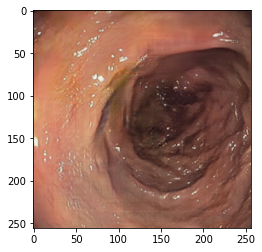

In [115]:
plt.imshow(from_torch(output))

  0%|          | 0/400 [00:00<?, ?it/s]

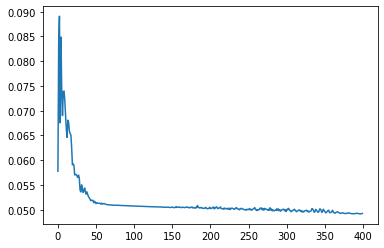

In [116]:
output = improve_noise_mse(noise=new_noise, lr=0.05)

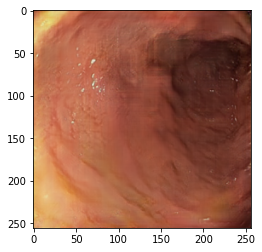

In [117]:
plt.imshow(from_torch(output))

  0%|          | 0/400 [00:00<?, ?it/s]

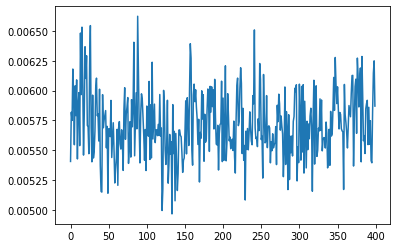

In [119]:
output = improve_noise_with_features(resnet, noise=new_noise, lr=0.05)

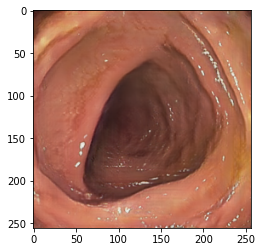

In [120]:
plt.imshow(from_torch(output))

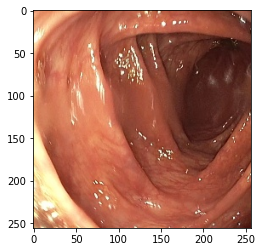

In [121]:
plt.imshow(from_torch(img))